### TPC2 MCE 2023-24

É dia de festa! E o prato principal é leitão assado no forno. Mas a vida está cara, conseguimos comprar o leitão a um preço mais em conta no produtor(pessoa de confiança!) e vamos assar no forno lá em casa. O problema é que nunca fizemos isto, e se der asneira a despesa é grande e a festa fica um pouco estragada (embora a companhia seja o mais importante, não é?)! Por isso procuramos instruções na Web. E encontramos no site https://www.seriouseats.com/whole-roasted-suckling-pig-recipe algumas indicações. Parece que o importante é alcançar a temperatura certa no sítio certo, de modo a estar perfeitamente cozinhado. Assim, queremos começar com o forno a $150^{o}C$ e deverá estar pronto quando a temperatura no ombro (bem fundo) atinja $70^{o}C$. Depois tostar a pele deve ser fácil.

Mas um físico testa primeiro! E aqui, não havendo leitões baratos para testar, simulamos! Temos um forno de $60$cm de altura por $60$cm de largura, e para não demorar a simulação mais do que a assadura, supomos que é uma boa aproximação reduzir o problema a 2D. O nosso leitão tem cerca de $45cm$ de comprimento, pelo que cabe no forno. Este tem duas resistências, uma em cima, outra em baixo, que alcançam temperaturas elevadas. Para simplificar, vamos supor que podemos considerar que a temperatura do ar dentro do forno é sempre a determinada pelo que indica o mostrador cá fora.

O leitão é colocado no forno apenas quando o termóstato desliga ao atingir a temperatura pré-definida (os $150^{o}C$). E somos lestos, logo não há tempo para descer a temperatura. Daí em diante qualquer variação da temperatura é rapidamente contrariada pelo termóstato, que liga as resistências e repõe a temperatura. Assim, podemos supor que a temperatura do ar dentro do forno é sempre $150^{o}C$.

Inserimos um termómetro de cozinha bem fundo no ombro do leitão, que é o sítio mais difícil de aquecer. O termómetro envia por WiFi a leitura para o telemóvel (é, também não sabia que havia disto!), de modo a  não termos que abrir o forno e perturbar a temperatura. No instante $t=0$ o leitão, que veio do frigorífico onde esteve a marinar toda a noite, tem uma temperatura de $6^{o}C$.

A constante de difusão média da carne do leitão é $\alpha = 1.45\times 10^{-7} m^2/s$ (como sabemos ${\displaystyle \alpha ={\frac {k}{\rho c_{p}}}}$
onde $k$ é a condutividade térmica ($W/(m·K)$), $c_p$ é a capacidade calorífica específica ($J/(kg·K)$), e $\rho$ é a densidade ($kg/m^3$)).

Não se esqueça das unidades correctas para exprimir a temperatura.

Tem anexa uma silhueta do leitão para usar na simulação. Com esta pode criar uma máscara (0/1 ou /False/True) para os pontos onde há variação de temperatura (no leitão) versus aqueles onde a temperatura é constante (ar dentro do forno). Por exemplo, depois de importar a imagem para um array chamado _img_, faz _leitao_bool = img<0.8_. Onde este array dá falso, queremos que a temperatura seja constante. (Nota1: o conceito de máscara pode ser confuso: onde a condição dá verdadeiro a máscara tem falso, que quer dizer aqui não se mexe; é como se fosse o negativo; Nota2: não especifiquei exactamente o local onde deve ser lida a temperatura com o termómetro, para avaliar o estado de assadura; como é evidente esse ponto deve ser na parte mais interna do leitão! Podem ignorar esse ponto e considerar que está assado quando a temperatura mínima dentro do leitão atingir os $70^{o}C$).

In [70]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from PIL import Image
from typing import Callable

a) Defina o seu domínio de simulação, indicando as suas dimensões, a sua grelha, as condições fronteira, e as condições iniciais, e tudo o mais necessário para definir bem o problema.
Importe a imagem fornecida e crie uma máscara para usar posteriormente. Só precisamos de uma imagem em cinzento de modo a distinguir o que é leitão do que não é. E note que o leitão enche esta imagem, mas não deve encher o domínio (são indicadas dimensões no enunciado acima).

Vamos indicar os parâmetros do problema em unidades SI, uma vez que todos valores são de uma ordem grandeza suficientemente próxima de $1$ para não ser necessário adimensionalizar o problema.

In [71]:
# Parâmetros do Problema (Unidades SI, Temperatura em Celsius)

# Dimensões e Temperatura do Forno
FORNOX = 0.60
FORNOY = 0.60
FORNOT = 150 + 273.15

# Dimensões e Temperatura do Leitão
LEITAOX = 0.45
LEITAOTI = 6
LEITAOTF = 70

# Coeficiente de difusão
DIF = 1.45e-7


# Parâmetros da Simulação

# Número de pontos a usar
NX = 701
NY = 701

# Espaçamento entre pontos da grelha
DX = FORNOX / (NX-1)
DY = FORNOY / (NY-1)

Podemos então importar a imagem e criar um array onde irá estar guardada a temperatura em cada ponto, bem como a máscara que indica que pontos podem evoluir no tempo.

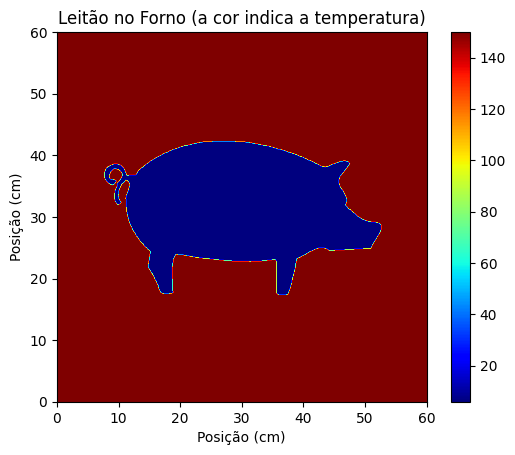

In [72]:
# Importar a imagem
leitao = Image.open("leitao_bw.png")

# Tamanho da imagem
XMAX, YMAX = leitao.size
LEITAOY = LEITAOX * (YMAX / XMAX)

# Espaçamento entre pontos da grelha da imagem do leitão
NXLEITAO = int(LEITAOX / FORNOX * NX)
NYLEITAO = int(LEITAOY / FORNOY * NY)

DXLEITAO = LEITAOX / (NXLEITAO - 1)
DYLEITAO = LEITAOY / (NYLEITAO - 1)

# Transformar em array
ll = np.array(leitao)

# Posicionamos o leitão de forma a que fique no centro do forno
NXI = (NX - NXLEITAO) // 2
NYI = (NY - NYLEITAO) // 2

# Interpolar a imagem png para obter a resolução desejada
xx = np.arange(XMAX)
yy = np.arange(YMAX)
coords = []

MULTX = DXLEITAO * NXLEITAO / XMAX
MULTY = DYLEITAO * NYLEITAO / YMAX
for i in range(XMAX):
    for j in range(YMAX):
        coords += [(XI + i * MULTX, YI + j * MULTY)]

interpol = sp.interpolate.LinearNDInterpolator(coords, ll.flatten(order="F"), fill_value=0)

# Colocar o leitão dentro do forno e definir a grelha
xx = np.linspace(0, FORNOX, NX)
yy = np.linspace(0, FORNOY, NY)
mx, my = np.meshgrid(xx, yy)
ll = interpol(mx, my)

# Fazer a máscara que indica onde está o leitão
leitao = ll > 240

# Aplicar as condições iniciais (que incluem as condições fronteira graças a máscara que criamos)
forno = np.zeros_like(ll)
forno[:, :] = 150
forno[leitao] = 6

# Ver a imagem
plt.imshow(forno, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title("Leitão no Forno (a cor indica a temperatura)")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

b) Escolha um dos métodos **estáveis** que aprendemos na UC. Determine as condições de estabilidade neste caso. Tendo em conta a grelha que escolheu em a), qual espera que seja o passo temporal máximo que pode usar?

Implemente o código necessário para resolver o nosso problema (na verdade já deve ter um código que faz isto dos exercícios da PL, dependendo do método que escolher).

Queremos resolver a equação da difusão para a temperatura (sendo $D = \alpha$ a constante de difusão):

\begin{align*}
\frac{\partial T}{\partial t} = D \nabla^2T
\end{align*}

Vamos usar o método de Euler em diante para calcular a derivada no tempo e a diferença central para as derivadas no espaço (método FTCS), obtendo a seguinte equação:

\begin{align*}
&\ \frac{T_{ij}^{n+1} - T_{ij}^{n}}{\Delta t} = \frac{D}{(\Delta x)^2}[T_{i+1j}^{n} + T_{i-1j}^{n} - 2T_{ij}^{n}] + \frac{D}{(\Delta y)^2}[T_{ij+1}^{n} + T_{iji-1}^{n} - 2T_{ij}^{n}]\Leftrightarrow
\\\\
\Leftrightarrow&\ T_{ij}^{n+1} = T_{ij}^n + F_x[T_{i+1j}^n + T_{i-1j}^n - 2T_{ij}^n] + F_y[T_{ij+1}^n + T_{ij-1}^n - 2T_{ij}^n]
\end{align*}

Onde:
- $T_{ij}^n = T(x = i\Delta x, y = j \Delta y, t = n\Delta t)$
- $F_x = D \cdot \Delta t / (\Delta x)^2$
- $F_y = D \cdot \Delta t / (\Delta y)^2$

Podemos determinar a região de estabilidade através de uma análise de Von Neumann. Para tal basta fazer a seguinte substituição no esquema de diferenças finitas de modo a determinar o fator de amplificação:
\begin{align*}
T_{ij}^n \to c_{k_xk_y}^ne^{i(k_xx + k_yy)}
\end{align*}

Temos então que, omitindo o índice da componente $c$ por ser sempre $k_xk_y$:
\begin{align*}
&\ T_{ij}^{n+1} = T_{ij}^n + F_x[T_{i+1j}^n + T_{i-1j}^n - 2T_{ij}^t] + F_y[T_{ij+1}^n + T_{ij-1}^n - 2T_{ij}^t]\rArr
\\\\
\rArr&\ c^{n+1}= c^n + \frac{D}{(\Delta x)^2}[c^ne^{ik_x\Delta x} + c^ne^{-ik_x\Delta x} - 2c^n] + \frac{D}{(\Delta y)^2}[c^ne^{ik_y\Delta y} + c^ne^{-ik_y\Delta y} - 2c^n]\Leftrightarrow
\\\\
\Leftrightarrow&\ c^{n+1} = \left[1+F_x(2\cos(k_x\Delta x) - 2) + F_y(2\cos(k_y\Delta y) - 2)\right]c^n
\\\\
\Leftrightarrow&\ c^{n+1} = \left[1 - 4F_x\sin^2\frac{k_x\Delta x}{2} - 4F_y\sin^2\frac{k_y\Delta y}{2}\right]c^n
\end{align*}

O método é estável se o fator de amplificação for em módulo inferior a $1$:
\begin{align*}
\left|1 - 4F_x\sin^2\frac{k_x\Delta x}{2} - 4F_y\sin^2\frac{k_y\Delta y}{2}\right| \le 1 &\rArr 1 - 4F_x\sin^2\frac{k_x\Delta x}{2} - 4F_y\sin^2\frac{k_y\Delta y}{2} \ge -1
\\\\
&\Leftrightarrow 2 \ge 4F_x\sin^2\frac{k_x\Delta x}{2} + 4F_y\sin^2\frac{k_y\Delta y}{2}
\end{align*}

Para que seja válido para todo $k_x\Delta x$ e $k_y\Delta y$ podemos considerar os senos igual a $1$:
\begin{align*}
2 \ge 4F_x + 4F_y &\Leftrightarrow F_x+ F_y \le \frac12
\\\\
&\Leftrightarrow D\cdot \frac{\Delta t}{(\Delta x)^2} + D\cdot \frac{\Delta t}{(\Delta y)^2}\le \frac12
\\\\
&\Leftrightarrow \Delta t\left(\frac1{(\Delta x)^2} + \frac1{(\Delta y)^2}\right)\le \frac1{2D}
\\\\
&\Leftrightarrow \Delta t\le \frac1{2D\left(\frac1{(\Delta x)^2} + \frac1{(\Delta y)^2}\right)}
\end{align*}

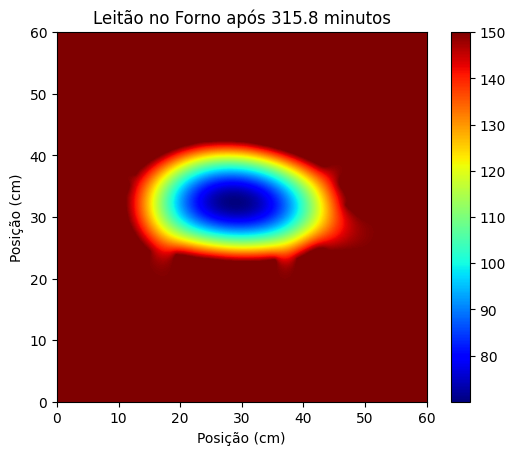

In [73]:
def calorFTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dtMult = 0.99, terminar=None):
    """
        Evolui a equação do calor por um tempo `T` com o método FTCS com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dtMult` * (menor dt para o qual o método é estável)

        Caso `terminar` seja especificado termina a simulação quando o valor mínimo da temperatura ultrapassa `terminar`.

        Assume que os pontos na fronteira de `mask` são `False` (assumimos que a temperatura na fronteira está fixa).
    """

    # Copiar condições iniciais
    now = np.copy(ci)
    nex = np.copy(ci)

    # Verificar estabilidade
    dt = 1 / (2 * D * (1/dx**2 + 1/dy**2)) * dtMult

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)


    # Evoluir no tempo
    t = 0

    while t < T:
        nex[1:-1, 1:-1] = now[1:-1, 1:-1] + mask[1:-1, 1:-1] * (Fx * (now[2:, 1:-1] + now[:-2, 1:-1] - 2 * now[1:-1, 1:-1]) + Fy * (now[1:-1, 2:] + now[1:-1, :-2] - 2 * now[1:-1, 1:-1]))
            
        t += dt
        now = np.copy(nex)

        if terminar:
            if np.min(now) > terminar:
                return now, t
    
    return now, t



# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = calorFTCS(10 * 3600, fornoC, leitaoC, DIF, DX, DY, terminar=70)

# Desfazer o recorte
forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(forno, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

c) Faça a simulação do problema usando o código que escreveu. Daí responda à questão: quanto tempo demorará a assar o leitão?

Compare a temperatura média em todo o leitão com a sua temperatura mínima, em cada instante da sua simulação. Produza um gráfico em função do tempo dessas duas quantidades.

d) Indique alguns modos como poderia melhorar a modelização do problema, para além de fazer o problema em 3D.